## Frequentist vs. Bayesian modeling

### Linear regression example

This example uses a familiar linear regression example to show how the [pymc3](https://docs.pymc.io) package can be used for Bayesian statistical modeling.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cbsyst as cb

from scipy import stats
import statsmodels.formula.api as smf
import pymc3 as pm

In [27]:
filename07 = 'wcoa_cruise_2007/32WC20070511.exc.csv'

### Import data and create subset

In [28]:
df07 = pd.read_csv(filename07,header=29,
                  na_values=-999,
                  parse_dates=[[6,7]])

In [29]:
Csw07 = cb.Csys(DIC=df07['TCARBN'],
             TA=df07['ALKALI'],
             T_in=df07['CTDTMP'],
             S_in=df07['CTDSAL'],
             P_in=df07['CTDPRS'])

In [30]:
Ca = 0.0102821e-6 # Calcium ion concentration in seawater (molar units)
df07['OmegaA'] = (Ca*Csw07['CO3'])/(Csw07.Ks['KspA'])

In [31]:
# select subset of good data
ii = ((df07['CTDPRS'] >= 30) & (df07['CTDPRS'] <= 300) & 
      (df07['NITRAT_FLAG_W'] == 2) & (df07['PHSPHT_FLAG_W'] == 2)
      & (df07['CTDOXY_FLAG_W'] == 2) & (df07['CTDSAL_FLAG_W'] == 2)
      & (df07['TCARBN_FLAG_W'] == 2) & (df07['ALKALI_FLAG_W'] == 2))

### Model

The goal of this analysis is to create a linear model of nitrate as a function of phosphate, based on the data from the 2007 West Coast Ocean Acidification (WCOA) cruise. In this case, $y_i$ represents the nitrate observations and $x_i$ represents the phosphate observations.

$$ \hat{y_i} = \beta_0 + \beta_1 x_i $$

There are two parameters in this model. The $\beta_0$ parameter is the intercept. This parameter is important because if it is positive, that means there is excess nitrate when phosphate is zero, indicating phosphate limitation. If it is negative, this means that nitrate tends to be limiting.

The $\beta_1$ parameter is the slope of the linear equation. This parameter is an indication of the ratio at which nitrate and phosphate are consumed during microbial respiration (or produced during photosynthesis).

This analysis will attempt to estimate the slope parameter $\beta_1$, and provide estimates of its uncertainty using frequentists and Bayesian approaches.

#### Standard frequentist linear regression - Method 1

The `scipy.stats` library can be used to used to estimate the slope and intercept parameters, as well as confidence intervals.

In [33]:
result = stats.linregress(df07['PHSPHT'][ii],df07['NITRAT'][ii])

In [39]:
result

LinregressResult(slope=14.506666639052389, intercept=-3.6501206026372266, rvalue=0.9704341145714541, pvalue=0.0, stderr=0.12303502278490003)

Text(0, 0.5, 'Nitrate [$\\mu$mol/kg]')

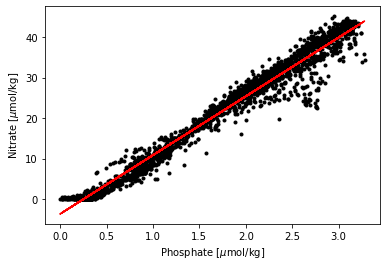

In [115]:
plt.figure()
plt.plot(df07['PHSPHT'],df07['NITRAT'],'k.')
plt.plot(df07['PHSPHT'],result.intercept+df07['PHSPHT']*result.slope,'r-')
plt.xlabel('Phosphate [$\mu$mol/kg]')
plt.ylabel('Nitrate [$\mu$mol/kg]')

Calculate 95% confidence intervals for slope. Note that the `stderr` returned by `stats.linregress` is the standard error of the slope.

The critical t-value for $\alpha$ = 0.05 is close to 1.96 in this case since $N$ is high.

In [51]:
alpha = 0.05 # significance level 
N = len(ii)  # number of samples
t = stats.t.ppf(0.975,N-2) # critical t-value (given alpha and DOF)

print('N = ', N)
print('t = ', round(t,4))
ci_lower_bound = result.slope - t*result.stderr
ci_upper_bound = result.slope + t*result.stderr
print('95% CI: ',round(ci_lower_bound,3),
      '< slope < ',round(ci_upper_bound,3))

N =  2348
t =  1.961
95% CI:  14.265 < slope <  14.748


##### Exercises:

* What do the 95% confidence intervals mean?

* True or False: These confidence intervals mean that there is a 95% chance that the true slope is between 14.265 and 14.748.

*Note:* Later, we will ask the same questions about the *credible intervals* estimated from Bayesian statistics.

#### Standard frequentist linear regression - Method 2

The regression parameters and confidence intervals can also be calculated using the `statsmodels` library. This gives the same exact result, but uses different syntax.

In [112]:
result_sm = smf.ols('NITRAT ~ 1 + PHSPHT',data=df07[ii]).fit()
result_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 NITRAT   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 1.390e+04
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:46:18   Log-Likelihood:                -1979.4
No. Observations:                 862   AIC:                             3963.
Df Residuals:                     860   BIC:                             3972.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6501      0.225    -16.227      0.000      -4.092      -3.209
PHSPHT        14.5067      0.123    117.907      0.000      14.265      14.748
==============================================================================
Omnibus:                      397.453   Durbin-Watson:                   0.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2328.978
Skew:                          -2.045   Prob(JB):                         0.00
Kurtosis:                       9.936   Cond. No.                         6.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear regression: Bayesian methods

Bayesian statistical modeling can be implemented using the [PyMC3](https://docs.pymc.io) package. This package uses Markov chain Monte Carlo (MCMC) methods.

* Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. [source: [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_method)]
* Markov chains, named after Andrey Markov, are mathematical systems that hop from one "state" (a situation or set of values) to another. [source: https://setosa.io/ev/markov-chains/]

In Bayesian modeling, different sets of model parameters are generated randomly. The *Monte Carlo* approach refers to the general approach of repeatedly generating many different combinations of parameters. The *Markov chain* is one class of algorithms that randomly samples different combinations of algorithms (or hops from one combination of parameters to another).

The *Monte Carlo* approach of repeatedly testing different parameter values in Bayesian modeling is similar to the nonlinear optimization process covered two weeks ago. However, the goals are slightly different. The goal of optimization is to quickly converge on the set of parameters that minimizes a cost function (like the root mean squared error). The goal of Bayesian modeling is to efficiently sample the full range of plausible parameters.

#### Terminology

$$\text{Pr}(\theta|x) = \frac{\text{Pr}(x|\theta)\text{Pr}(\theta)}{\text{Pr}(x)}$$

* $x$ - data (fixed)
* $\theta$ - parameters (variable)
* $\text{Pr}(\theta|x)$ - probability of the parameters, given the data (*posterior*)
* $\text{Pr}(\theta)$ - probability of the parameters, before incorporating the data  (*prior*)
* $\text{Pr}(x|\theta)$ - probability of the data, given the parameters (*likelihood*)
    * In Bayesian statistics, the data $x$ are fixed and the parameters $\theta$ are varied
* $\text{Pr}(x)$ - probability of the data (*normalizing constant*)

The normalizing constant $\text{Pr}(x)$ is difficult, both conceptually and computationally. In practice, estimating $\text{Pr}(x)$ requires estimating $\text{Pr}(x|\theta)$ over many different possible parameter values $\theta$.

#### Three steps in Bayesian statistical analysis

Source: [Bayesian Statistical Analysis using Python](https://www.youtube.com/watch?v=vOBB_ycQ0RA)
YouTube Video by Chris Fonnesbeck, PyMC3 developer

1. Specify a probability model
* *Prior* probabilities of parameters
* *Likelihood* function (model equation) that connects the data to the parameters
2. Calculate a posterior distribution
* This is where MCMC comes in
3. Check your model
* Does the model fit the data?
* Are the conclusions reasonable?
* Are the outputs sensitive to model structure?
    * Do the results change if different priors are used?

#### Probability distributions

Probability distrubutions are the foundation of Bayesian statistical modeling. This example will use the familiar Normal distribution and the less-familiar Half-Cauchy distribution. An important feature of the Half-Cauchy distribution is that it assigns a probability to all non-negative numbers.

(-50.0, 50.0)

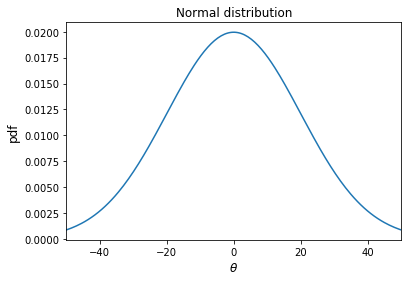

In [142]:
theta = np.linspace(-50, 50, 200)
mu = 0.0
sigma = 20.0
pdf = stats.norm.pdf(theta,loc=mu,scale=sigma)
plt.plot(theta, pdf)
plt.xlabel('$\\theta$', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.title('Normal distribution')
plt.xlim([np.min(theta),np.max(theta)])

(0.0, 50.0)

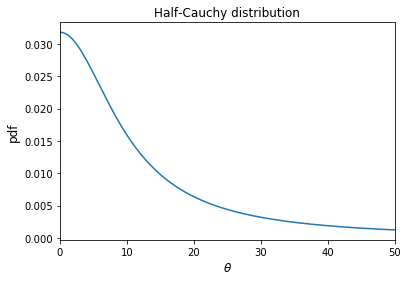

In [144]:
theta = np.linspace(0, 50, 200)
b = 10.0
pdf = stats.cauchy.pdf(theta, scale=b)
plt.plot(theta, pdf)
plt.xlabel('$\\theta$', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.title('Half-Cauchy distribution')
plt.xlim([np.min(theta),np.max(theta)])

### Model

The goal of this analysis is to create a linear model of nitrate as a function of phosphate, based on the data from the 2007 West Coast Ocean Acidification (WCOA) cruise. In this case, $y_i$ represents the nitrate observations and $x_i$ represents the phosphate observations.

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

The $\epsilon_i$ term in this equation represents the *error*, or *residual*, or *model-observation difference*.

In linear regression, it is expected that the errors will be normally distributed. The standard deviation of the errors will be a parameter in the model. This parameter has to be positive (standard deviation cannot be negative).

We need to specify a *prior* probability distribution for three parameters:
* intercept, $\beta_0$
* slope, $\beta_1$
* standard deviation of the errors, std($\epsilon_i$)

### Observations

In [156]:
x = df07['PHSPHT'][ii]
y = df07['NITRAT'][ii]

In [157]:
from pymc3 import Model, sample, Normal, HalfCauchy

In [158]:
# model specifications in PyMC3 are wrapped in a with-statement
with Model() as NP_model: 
    # Define priors
    intercept = Normal('intercept', 0, sigma=20)
    slope = Normal('slope', 0, sigma=20)
    error_std = HalfCauchy('error_std', beta=10)
    
    # Define likelihood function
    # the likelihood function defines a model that links the data to the parameters
    yhat = intercept + slope*x
    likelihood = Normal('yhat', mu=yhat,
                        sigma=error_std, observed=y)

    # Calculate a posterior distribution
    posterior = sample(3000,cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [error_std, slope, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:06<00:00, 1155.22draws/s]
The acceptance probability does not match the target. It is 0.9093735374545645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012613254251249, but should be close to 0.8. Try to increase the number of tuning steps.


<Figure size 432x288 with 0 Axes>

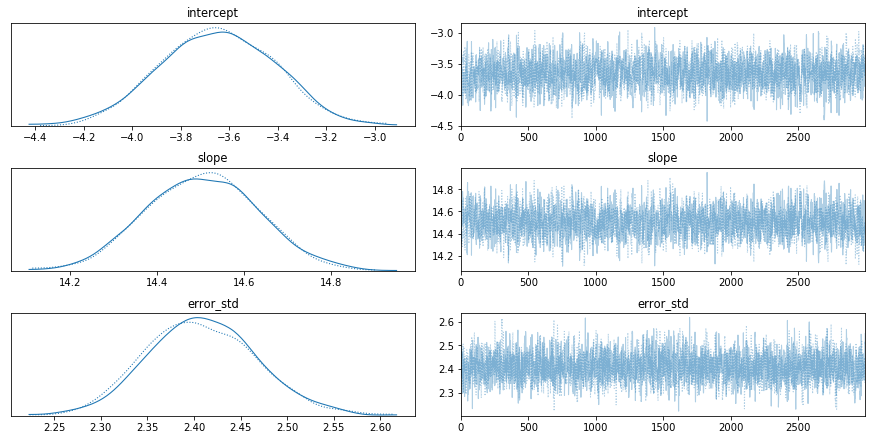

In [159]:
from pymc3 import plot_posterior,traceplot

plt.figure()
traceplot(posterior);

/Users/tomconnolly/programs/anaconda/envs/ms263/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x135ed0f10>],
      dtype=object)

<Figure size 432x288 with 0 Axes>

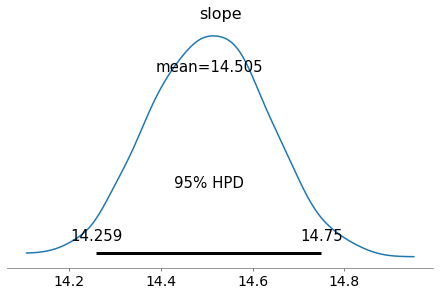

In [160]:
plt.figure()
plot_posterior(posterior,varnames=['slope'],round_to=5,credible_interval=0.95)

##### Exercises:

* What do the 95% credible intervals mean?

* True or False: There is a 95% chance that the true slope lies within the credible interval.

* Sensitivity analysis - alter the prior distributions (save your notebook first). How does this affect the results?

#### Empirical Bayes

Simple syntax in PyMC3, but controversial even among Bayesians.

Same model, but notice that no priors are specified here. The priors are automatically generated from the data using frequentist statistics 🤔

In [161]:
from pymc3 import GLM

In [162]:
with Model() as NP_model_2:
    GLM.from_formula('y ~ x', df07[ii])
    posterior_2 = sample(3000,cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:06<00:00, 1007.90draws/s]
The acceptance probability does not match the target. It is 0.9407569326900844, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9108210304255395, but should be close to 0.8. Try to increase the number of tuning steps.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x137178d50>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

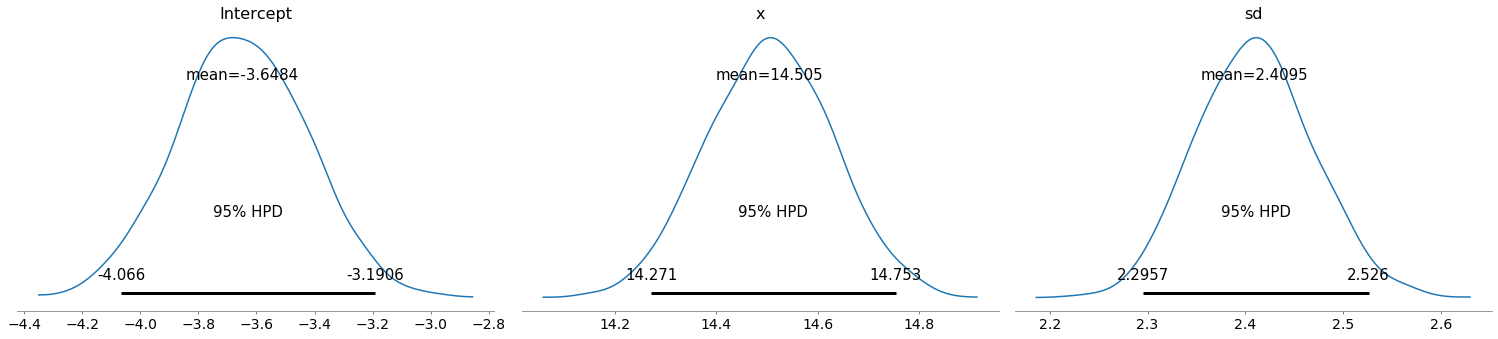

In [163]:
plt.figure()
plot_posterior(posterior_2,round_to=5,credible_interval=0.95)

##### Exercise (if time)

Consider the following model for aragonite saturation state based on oxygen and temperature:

$ \hat{\Omega}_A = a_0 + a_1 \times (O - Oref) + a_2 \times (O - Oref) \times (T - Tref) $

Calculate 95% credible intervals for the coefficients $a_0$, $a_1$ and $a_2$ using PyMC3.